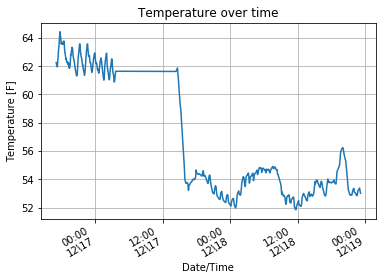

In [12]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pytz import timezone

def get_data():
    dynamodb = boto3.resource('dynamodb')
    table = dynamodb.Table('iot-temp')

    response = table.scan()
    data = response.get('Items', [])
    temps = [item['payload'] for item in data]
    return pd.DataFrame(temps)

def process_data(df):
    df['temp'] = df['temp'].apply(lambda x: float(x))
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000, timezone('America/Los_Angeles')))
    df.set_index('timestamp', inplace = True)
    df.sort_values(by='timestamp', inplace = True)
    return df

def average_data(df):
    return df.rolling(15).mean()

def format_plot(ax):
    hours = mdates.HourLocator(byhour=[0, 12], tz=timezone('America/Los_Angeles'))
    ax.xaxis.set_major_locator(hours)

    years_fmt = mdates.DateFormatter('%H:%M\n%m\%d', tz=timezone('America/Los_Angeles'))
    ax.xaxis.set_major_formatter(years_fmt)

    ax.set_xlabel('Date/Time')
    ax.set_ylabel('Temperature [F]')
    ax.get_legend().remove()

df = get_data()
df = process_data(df)
df = average_data(df)

ax = df.plot(grid=True, title='Temperature over time')
format_plot(ax)